In [1]:
#!pip install dgl-cu100

In [2]:
#!pip install scipy --upgrade

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import dgl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Using backend: pytorch


### Attention Mechanisms

The task is object detection around a cloud of points. The goals are:

1. Learn about heterogeneous graphs in DGL (graphs with multiple types of nodes and edges)
2. Implement key query attention
3. Learn about slot attention and permutation invariant loss


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if not os.path.exists('Dataset.zip'):
    !wget https://www.dropbox.com/s/qrivkcb50yliez9/Dataset.zip

In [4]:
if not os.path.exists('Dataset'):
    !unzip Dataset.zip

In [5]:
from dataloader import RandomShapeDataset, collate_graphs,plot_graph

In [6]:
dataset = RandomShapeDataset('Dataset/training.bin')
validation_ds = RandomShapeDataset('Dataset/validation.bin')

In [7]:
dataset[0]

Graph(num_nodes={'objects': 3, 'points': 379, 'predicted objects': 3},
      num_edges={('points', 'points_to_object', 'predicted objects'): 1137, ('predicted objects', 'pred_to_target', 'objects'): 9},
      metagraph=[('points', 'predicted objects', 'points_to_object'), ('predicted objects', 'objects', 'pred_to_target')])

IMG_3C22A4FDEC0D-1.jpeg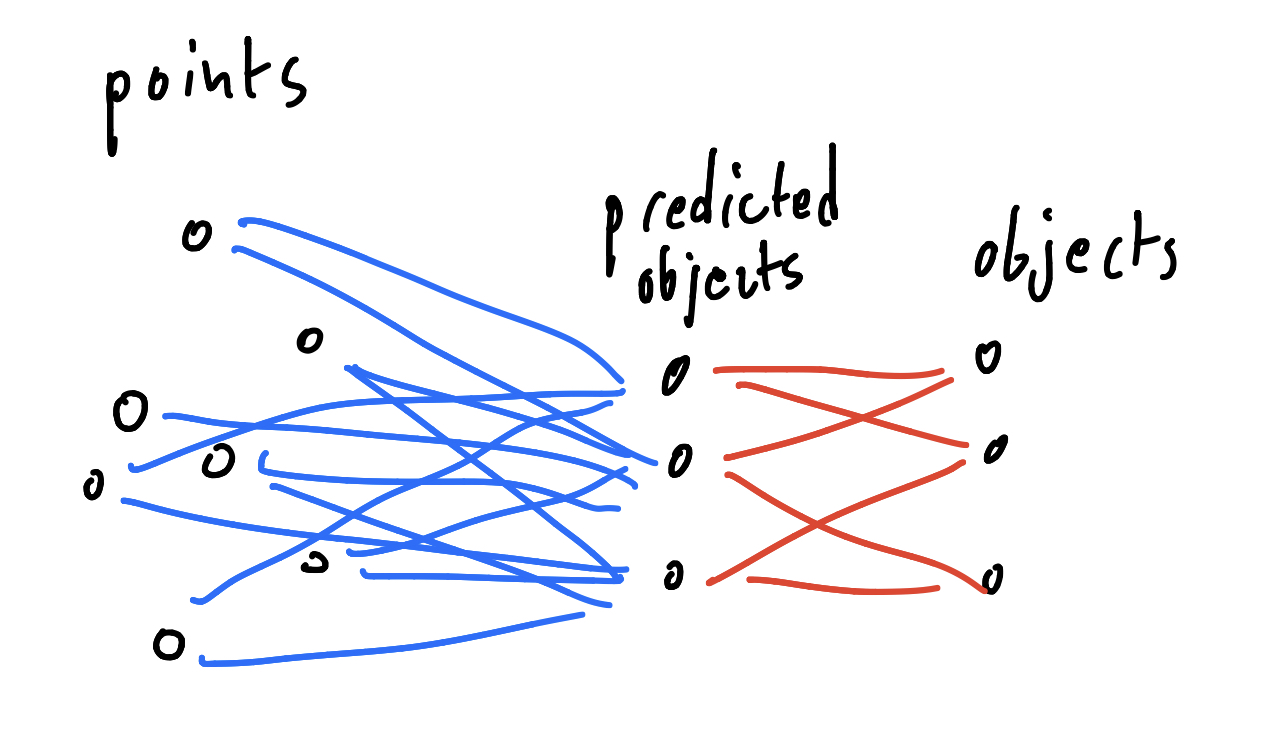

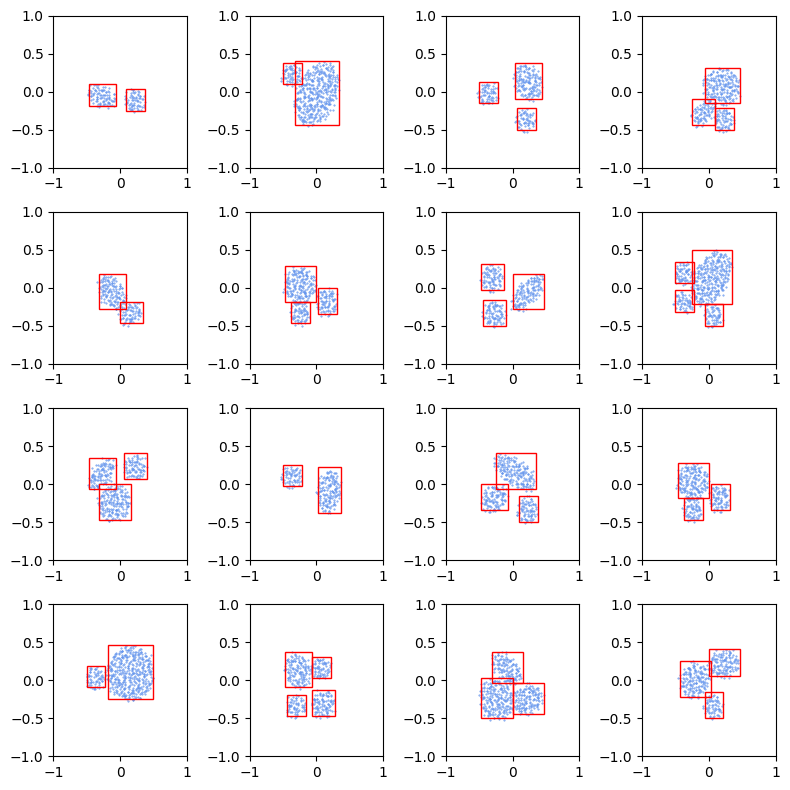

In [8]:
fig,ax = plt.subplots(4,4,figsize=(8,8),dpi=100)

for i in range(4):
    for j in range(4):
        ax_i = ax[i][j]
        g = validation_ds[np.random.randint(len(validation_ds))]
        plot_graph(g,ax_i,size=0.2)


plt.tight_layout()
plt.show()

In [9]:
from torch.utils.data import Dataset, DataLoader

data_loader = DataLoader(dataset, batch_size=300, shuffle=True,
                         collate_fn=collate_graphs)

valid_data_loader = DataLoader(validation_ds, batch_size=300, shuffle=False,
                         collate_fn=collate_graphs)

In [10]:
for batched_g in data_loader:
    break

In [11]:
batched_g

Graph(num_nodes={'objects': 865, 'points': 101725, 'predicted objects': 865},
      num_edges={('points', 'points_to_object', 'predicted objects'): 304105, ('predicted objects', 'pred_to_target', 'objects'): 2655},
      metagraph=[('points', 'predicted objects', 'points_to_object'), ('predicted objects', 'objects', 'pred_to_target')])

In [12]:
#Number of clusters
batched_g.batch_num_nodes('objects')

tensor([3, 4, 3, 3, 3, 3, 2, 4, 2, 4, 3, 2, 3, 2, 4, 3, 3, 2, 2, 3, 2, 2, 2, 3,
        4, 2, 3, 2, 3, 2, 2, 3, 4, 3, 2, 3, 2, 3, 3, 4, 3, 3, 3, 3, 3, 2, 4, 3,
        4, 3, 3, 4, 2, 3, 2, 2, 4, 4, 2, 2, 3, 3, 4, 2, 2, 3, 3, 3, 4, 3, 4, 4,
        4, 2, 2, 2, 3, 2, 4, 2, 3, 2, 2, 3, 2, 4, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        3, 3, 2, 3, 3, 4, 2, 2, 2, 3, 4, 3, 4, 2, 3, 2, 2, 3, 2, 3, 3, 4, 4, 3,
        4, 3, 2, 4, 2, 3, 3, 3, 3, 2, 2, 4, 4, 2, 2, 2, 3, 4, 3, 2, 3, 3, 2, 2,
        3, 4, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 2, 3, 2, 2, 4, 3, 3,
        4, 2, 4, 2, 2, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3,
        3, 4, 3, 4, 4, 3, 2, 3, 3, 2, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        4, 3, 3, 3, 2, 2, 2, 3, 2, 4, 4, 3, 3, 3, 4, 3, 2, 2, 4, 4, 4, 2, 2, 3,
        2, 3, 3, 4, 4, 2, 4, 3, 3, 2, 4, 2, 3, 3, 3, 2, 4, 3, 3, 3, 4, 3, 3, 3,
        3, 2, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 2, 4, 3, 3, 2, 3, 4, 3, 3, 3, 2, 2,
        3, 4, 2, 2, 3, 2, 4, 3, 2, 2, 2,

In [13]:
#Since it's an heterogeneous graph we need to specify which nodes are we dealing with 
batched_g.nodes['points'].data

{'xy': tensor([[-0.5120,  0.0261],
        [-0.4646, -0.0042],
        [-0.4721,  0.0208],
        ...,
        [ 0.2977,  0.0108],
        [ 0.3040,  0.0381],
        [ 0.3087,  0.0269]])}

## The model

It is based on Object-Centric Learning with Slot Attention, https://arxiv.org/abs/2006.15055. I will analyze all the different components of this model.

IMG_F010FAB7ABEB-1.jpeg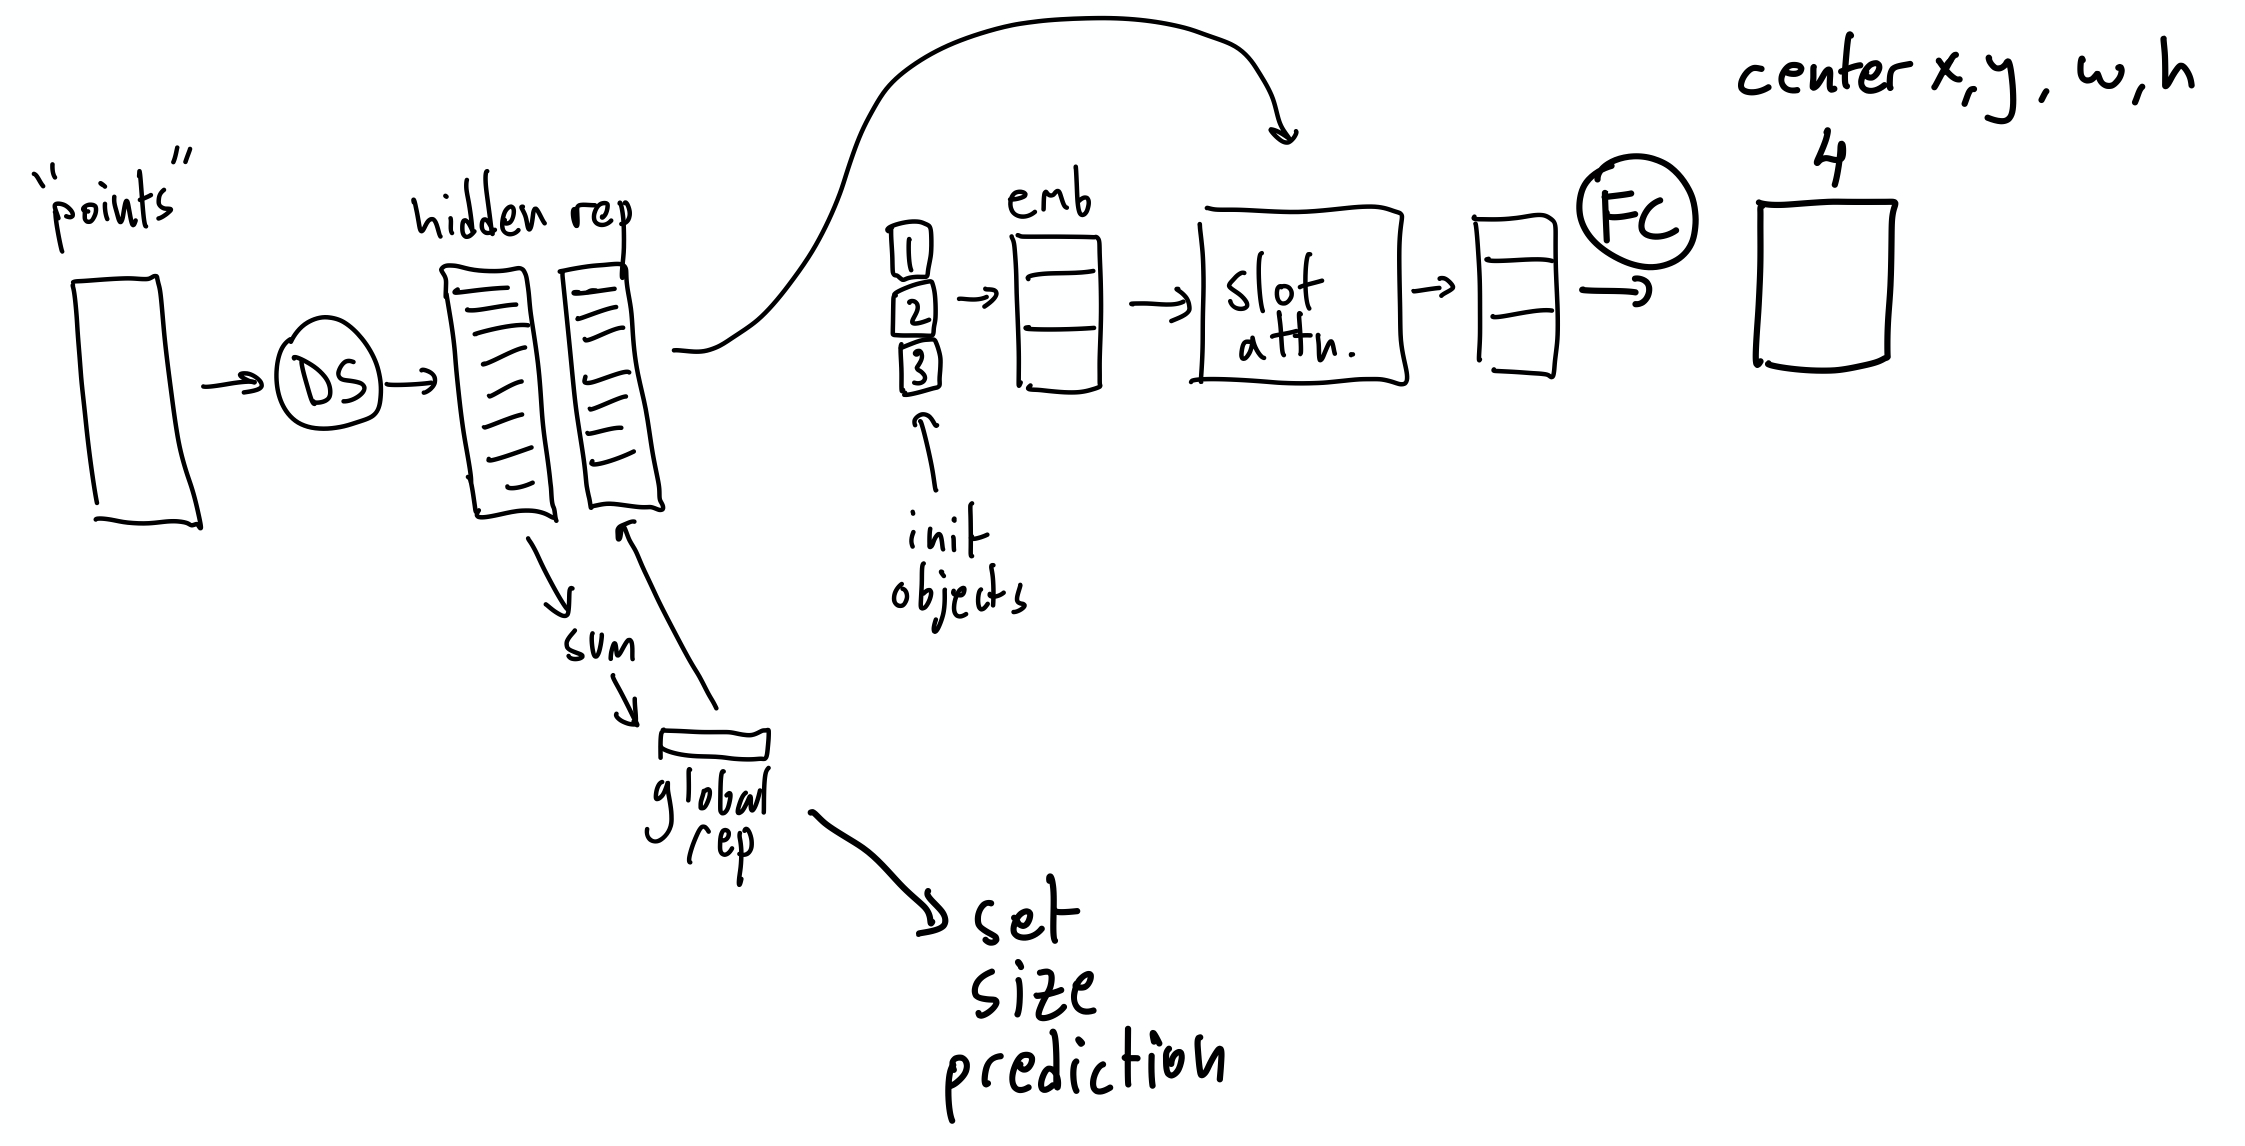

IMG_86B9C9D9C656-1.jpeg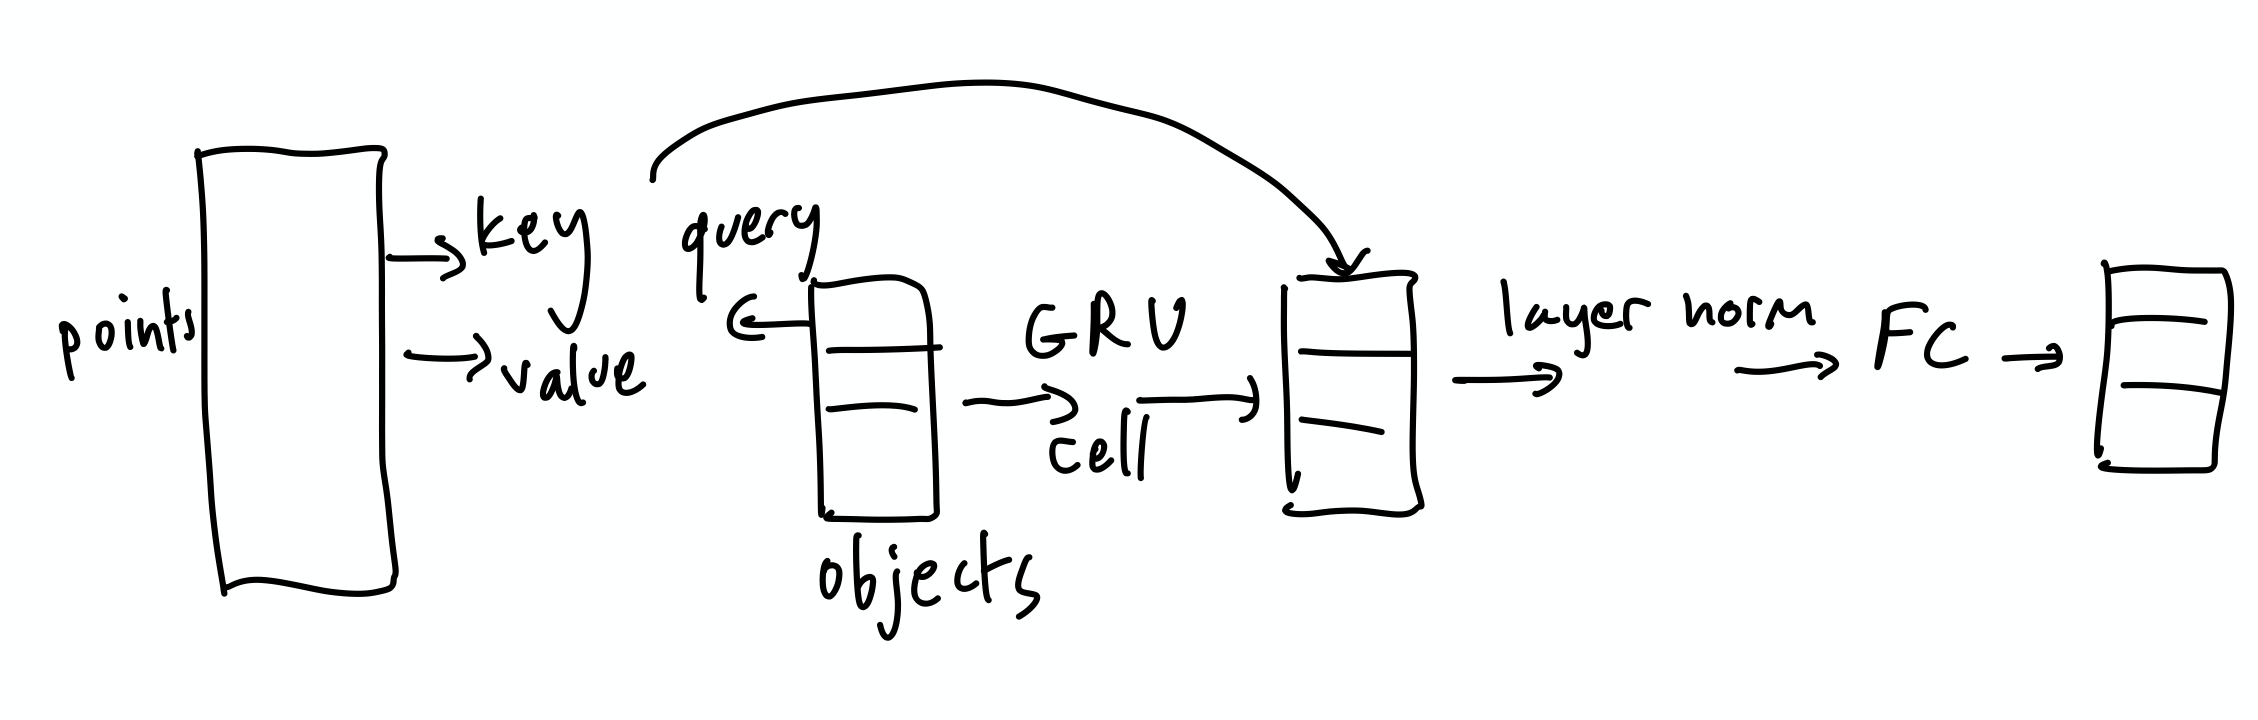

### Analysis of DeepSet and SlotAttention

I decompose the different part of the model here to understand them (and debug).

In [16]:
class Deepset(nn.Module):
    def __init__(self):
        super().__init__()
        
        input_size = 2
        hidden_size = 50
        
        self.node_init = nn.Linear(input_size,hidden_size)
        self.hidden_layers = nn.ModuleList()
        
        for i in range(2):
            self.hidden_layers.append( 
                nn.Sequential(
                    nn.Linear(hidden_size*2,hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size,hidden_size), 
                    nn.ReLU(),
                    nn.Linear(hidden_size,hidden_size), 
                    nn.ReLU(),
                    nn.Linear(hidden_size,hidden_size), 
                    nn.ReLU(),
                    nn.Linear(hidden_size,hidden_size),
                    nn.BatchNorm1d(hidden_size)
                )
            )
            
    def forward(self,g):
        
        g.nodes['points'].data['hidden rep'] = self.node_init(g.nodes['points'].data['xy'])
        
        for layer_i, layer in enumerate(self.hidden_layers):
                                
            mean_of_node_rep = dgl.mean_nodes(g,'hidden rep',ntype = 'points')
            broadcasted_mean = dgl.broadcast_nodes(g,mean_of_node_rep,ntype = 'points')
            g.nodes['points'].data['global rep'] = broadcasted_mean

            input_to_layer = torch.cat([g.nodes['points'].data['global rep'],g.nodes['points'].data['hidden rep']],dim=1)
                      
            features = self.hidden_layers[layer_i](input_to_layer)
            
            g.nodes['points'].data['hidden rep'] = features

In [17]:
for batched_g in data_loader:
    break

In [18]:
deepset = Deepset()

In [19]:
deepset(batched_g)

After running the DeepSet I have to:

1. Create the size prediction
2. Create the object prediction (center, width and height) in case of training

In [20]:
# Size prediction example

output_size_predictor = 3
hidden_size = 50

size_predictor = nn.Sequential(
    nn.Linear(hidden_size,int(hidden_size/2)),
    nn.ReLU(),
    nn.Linear(int(hidden_size/2),int(hidden_size/2)),
    nn.ReLU(),
    nn.Linear(int(hidden_size/2),int(hidden_size/2)),
    nn.ReLU(),
    nn.Linear(int(hidden_size/2),output_size_predictor)
)

In [21]:
global_rep = dgl.mean_nodes(batched_g,'global rep',ntype='points')

size_prediction = size_predictor(global_rep)
size_prediction.shape

torch.Size([300, 3])

In [22]:
# Object prediction example

class SlotAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same as before
        hidden_size = 50
        
        # point_size corresponds to hidden_rep + x + y
        point_size = 50 + 2
        # objects_size corresponds to hidden_rep + global_rep
        objects_size = 50 + 50

        key_size = 10
        query_size = 10
        
        # the values size have to be reflect the hidden size
        values_size = hidden_size
        
        self.dk = 64

        self.key = nn.Linear(point_size, key_size)
        self.query = nn.Linear(objects_size, query_size)
        self.values = nn.Linear(point_size, values_size)

        self.gru = nn.GRUCell(hidden_size, values_size)

        self.layer_norm = nn.LayerNorm(values_size)
        
        self.norm = 1/torch.sqrt(torch.FloatTensor([key_size]))

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, self.dk),
            nn.ReLU(),
            nn.Linear(self.dk, hidden_size)
        )

    def edge_function(self, edges):

        attention = (edges.src['key'] * edges.dst['query']).sum(-1,keepdim = True) * self.norm
        values = edges.src['values']
        
        #print('--- EDGES ----')
        #print(attention.shape)

        # this line is not required so we can visualize the data afterwards
        edges.data['attention weights'] = attention

        return {'attention' : attention, 'values' : values}

    def node_update(self,nodes):
        
        #print('--- NODES ----')
        #print(nodes.mailbox['attention'].shape)
        #print(nodes.mailbox['values'].shape)
        
        attention_weights = torch.softmax(nodes.mailbox['attention'], dim = 1)
        #print(attention_weights.shape)
        weighted_sum = torch.sum(attention_weights * nodes.mailbox['values'], dim = 1)
                
        # update the hidden rep based on the existing rep and 
        new_hidden_rep = nodes.data['hidden rep'] + self.mlp(self.layer_norm(self.gru(weighted_sum,nodes.data['hidden rep'])))
        
        #print(weighted_sum.shape)
        
        return {'hidden rep': new_hidden_rep }

    def forward(self, g):
        
        self.norm = self.norm.to(g.device)

        point_inputs = torch.cat([g.nodes['points'].data['hidden rep'],g.nodes['points'].data['xy']],dim=1)
        objects_input = torch.cat([g.nodes['predicted objects'].data['hidden rep'],g.nodes['predicted objects'].data['global rep']],dim=1)

        g.nodes['points'].data['key'] = self.key(point_inputs)
        g.nodes['points'].data['values'] = self.values(point_inputs)
        g.nodes['predicted objects'].data['query'] = self.query(objects_input)

        g.update_all(self.edge_function,self.node_update,etype='points_to_object')

In [23]:
output_properties_prediction = 4
max_N = 4

z_init = nn.Embedding(max_N, hidden_size)

num_objects = batched_g.batch_num_nodes('predicted objects')

global_rep = dgl.mean_nodes(batched_g,'global rep',ntype='points')
batched_g.nodes['predicted objects'].data['global rep'] = dgl.broadcast_nodes(batched_g,global_rep,ntype='predicted objects')

# for every batch we say how many objects there are
z = torch.cat([torch.arange(N,device=batched_g.device) for N in num_objects])

batched_g.nodes['predicted objects'].data['hidden rep'] = z_init( z )

In [27]:
z_init( z )

tensor([[ 1.5027,  1.1072, -0.6978,  ..., -0.4646,  0.5262, -0.9661],
        [ 0.7504,  0.4959, -0.7403,  ..., -1.9444,  0.0210,  0.1687],
        [ 1.5027,  1.1072, -0.6978,  ..., -0.4646,  0.5262, -0.9661],
        ...,
        [ 1.5027,  1.1072, -0.6978,  ..., -0.4646,  0.5262, -0.9661],
        [ 0.7504,  0.4959, -0.7403,  ..., -1.9444,  0.0210,  0.1687],
        [ 0.9244, -0.6772, -0.5100,  ..., -0.6267, -0.5801, -0.4826]],
       grad_fn=<EmbeddingBackward>)

In [30]:
slotattentions = nn.ModuleList()
        
for i in range(3):
    slotattentions.append( SlotAttention() )

for slotattention in slotattentions:
    slotattention(batched_g)

In [31]:
properties_prediction = nn.Sequential(
    nn.Linear(hidden_size,int(hidden_size/2)),
    nn.ReLU(),
    nn.Linear(int(hidden_size/2),int(hidden_size/2)),
    nn.ReLU(),
    nn.Linear(int(hidden_size/2),int(hidden_size/2)),
    nn.ReLU(),
    nn.Linear(int(hidden_size/2),output_properties_prediction)
)

In [32]:
batched_g.nodes['predicted objects'].data['properties'] = properties_prediction(batched_g.nodes['predicted objects'].data['hidden rep'])

In [33]:
batched_g.nodes['predicted objects'].data['properties'].shape

torch.Size([855, 4])

I can now import my model.

In [34]:
from model import Net

In [35]:
net = Net()

In [36]:
for batched_g in data_loader:
    break

In [37]:
net.train();

In [38]:
predicted_g, size_pred = net(batched_g)

In [39]:
predicted_g, size_pred.shape

(Graph(num_nodes={'objects': 858, 'points': 101195, 'predicted objects': 858},
       num_edges={('points', 'points_to_object', 'predicted objects'): 299399, ('predicted objects', 'pred_to_target', 'objects'): 2608},
       metagraph=[('points', 'predicted objects', 'points_to_object'), ('predicted objects', 'objects', 'pred_to_target')]),
 torch.Size([300, 3]))

In [43]:
predicted_g.nodes['objects'].datata['']

NodeSpace(data={'centers': tensor([[ 0.2344,  0.2344],
        [-0.2969, -0.1719],
        [ 0.0469, -0.2344],
        ...,
        [-0.0469, -0.2344],
        [-0.2656,  0.0156],
        [ 0.1094, -0.2969]]), 'height': tensor([0.3438, 0.3438, 0.3438, 0.4062, 0.3438, 0.2812, 0.5938, 0.2812, 0.2812,
        0.2812, 0.5938, 0.2812, 0.2812, 0.4688, 0.2812, 0.7188, 0.2812, 0.2812,
        0.2812, 0.5312, 0.3438, 0.4688, 0.3438, 0.4688, 0.3438, 0.2812, 0.2812,
        0.2812, 0.2812, 0.4062, 0.3438, 0.6562, 0.4688, 0.2812, 0.6562, 0.2812,
        0.3438, 0.2812, 0.2812, 0.2812, 0.5938, 0.3438, 0.4688, 0.2812, 0.3438,
        0.4688, 0.4062, 0.2812, 0.2812, 0.3438, 0.5312, 0.5625, 0.2812, 0.3438,
        0.3438, 0.5938, 0.4062, 0.2812, 0.3438, 0.3438, 0.3438, 0.3438, 0.3438,
        0.5312, 0.2812, 0.2812, 0.2812, 0.5312, 0.4062, 0.2812, 0.2812, 0.4062,
        0.4062, 0.3438, 0.3438, 0.4688, 0.2812, 0.5312, 0.3438, 0.2812, 0.2812,
        0.5938, 0.2812, 0.2812, 0.2812, 0.2812, 0.4062, 0.34

In [41]:
predicted_g.nodes['predicted objects'].data['properties'].shape

torch.Size([858, 4])

## Permutation invariant loss

https://en.wikipedia.org/wiki/Hungarian_algorithm

The loss computation has to take into account the fact that there is no order to the output. I can predict the objects in whatever order i want, and the loss should not be affected by this.

IMG_A31A2DFBAB94-1.jpeg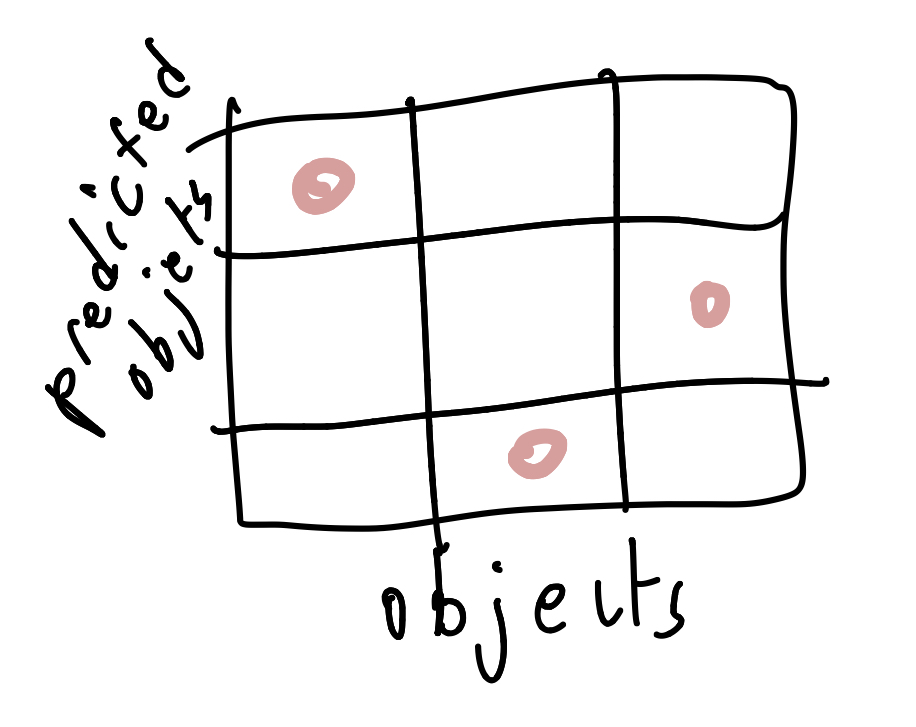

In [35]:
from loss import Set2SetLoss

In [36]:
loss_func = Set2SetLoss()

In [37]:
loss_func(batched_g)

tensor(0.8291, grad_fn=<MeanBackward0>)

In [38]:
size_loss_func = nn.CrossEntropyLoss()

In [39]:
size_loss_func(size_pred, batched_g.batch_num_nodes('objects')-2)

tensor(1.0981, grad_fn=<NllLossBackward>)

### Training the objects prediction

First I train the bounding boxes, since they do not care about the size prediction during training.

In [29]:
net = Net()

NameError: name 'Net' is not defined

In [41]:
dataset = RandomShapeDataset('Dataset/training.bin')
validation_ds = RandomShapeDataset('Dataset/validation.bin')

data_loader = DataLoader(dataset, batch_size=300, shuffle=True,
                         collate_fn=collate_graphs)

valid_data_loader = DataLoader(validation_ds, batch_size=300, shuffle=False,
                         collate_fn=collate_graphs)

In [42]:
optimizer = optim.Adam(net.parameters(), lr=0.0005) 

In [43]:
if torch.cuda.is_available():
    net.cuda()

In [44]:
training_loss_vs_epoch = []
validation_loss_vs_epoch = []

In [28]:
# I run it on colab

if torch.cuda.is_available():
    
    n_epochs = 400

    for epoch in range(n_epochs): 

        if len(validation_loss_vs_epoch) > 0:

            print(epoch, 'train loss',training_loss_vs_epoch[-1],'validation loss',validation_loss_vs_epoch[-1])

        net.train() # put the net into "training mode"

        epoch_loss = 0
        n_batches = 0
        for batched_g in tqdm(data_loader):
            n_batches+=1

            if torch.cuda.is_available():
                batched_g = batched_g.to(torch.device('cuda'))

            optimizer.zero_grad()

            predicted_g,size_pred = net(batched_g)

            loss = loss_func(batched_g) 

            epoch_loss+=loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = epoch_loss/n_batches
        training_loss_vs_epoch.append(epoch_loss)

        net.eval()
        with torch.no_grad():
            epoch_loss = 0
            n_batches = 0
            for batched_g in tqdm(valid_data_loader):
                n_batches+=1

                if torch.cuda.is_available():
                    batched_g = batched_g.to(torch.device('cuda'))

                predicted_g,size_pred = net(batched_g,use_target_size=True)

                loss = loss_func(batched_g) 

                epoch_loss+=loss.item()

            epoch_loss = epoch_loss/n_batches
            validation_loss_vs_epoch.append(epoch_loss)

        if len(validation_loss_vs_epoch)==1 or np.amin(validation_loss_vs_epoch[:-1]) > validation_loss_vs_epoch[-1]:
            torch.save(net.state_dict(), 'trained_model.pt')

In [46]:
if torch.cuda.is_available():

    plt.plot(training_loss_vs_epoch)
    plt.plot(validation_loss_vs_epoch)

In [47]:
#!cp trained_model.pt trained_model_objects.pt

In [48]:
net.cpu()
net.load_state_dict(torch.load('trained_model_objects.pt',map_location='cpu'))

<All keys matched successfully>

### Results of first training 

I check the results without training the size prediction.

In [49]:
net.eval()
net.cpu()
predicted_sizes = []
for batched_g in valid_data_loader:
    predicted_g,size_pred = net(batched_g)
    
    predicted_sizes+=list(torch.argmax(size_pred,dim=1).cpu().data.numpy())
    
predicted_sizes = np.array(predicted_sizes)+2

In [50]:
target_sizes = np.array([validation_ds[i].num_nodes('objects') for i in range(len(validation_ds))])

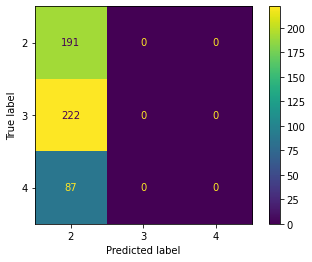

In [51]:
cm = confusion_matrix(target_sizes, predicted_sizes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['2','3','4'])
disp.plot()

In [52]:
# I randomly select a validation graph to check

idxValidation = 90

In [53]:
g = validation_ds[idxValidation].cpu()

net.eval()
predicted_g,size_pred = net(g) 

In [54]:
predicted_g.num_nodes('predicted objects')

3

In [55]:
x = g.nodes['points'].data['xy'][:,0].data.numpy()
y = g.nodes['points'].data['xy'][:,1].data.numpy()
object_centers = g.nodes['objects'].data['centers'].data.numpy()

object_width = g.nodes['objects'].data['width'].data.numpy()
object_height = g.nodes['objects'].data['height'].data.numpy()

predicted_heights = predicted_g.nodes['predicted objects'].data['properties'][:,0].data.numpy()
predicted_widths = predicted_g.nodes['predicted objects'].data['properties'][:,1].data.numpy()
predicted_centers = predicted_g.nodes['predicted objects'].data['properties'][:,[2,3]].data.numpy()

attn_weights = predicted_g.edges['points_to_object'].data['attention weights'].cpu().data.numpy()

In [56]:
n_points = predicted_g.num_nodes('points')
n_objects = predicted_g.num_nodes('predicted objects')
n_objects

3

In [57]:
estart = predicted_g.edges(etype='points_to_object')[0].cpu().data.numpy()
eend =  predicted_g.edges(etype='points_to_object')[1].cpu().data.numpy()

weight_dict = {i:{} for i in range(n_objects)}
for e_i,(es,ee) in enumerate(zip(estart,eend)):
    weight_dict[ee][es] = attn_weights[e_i]

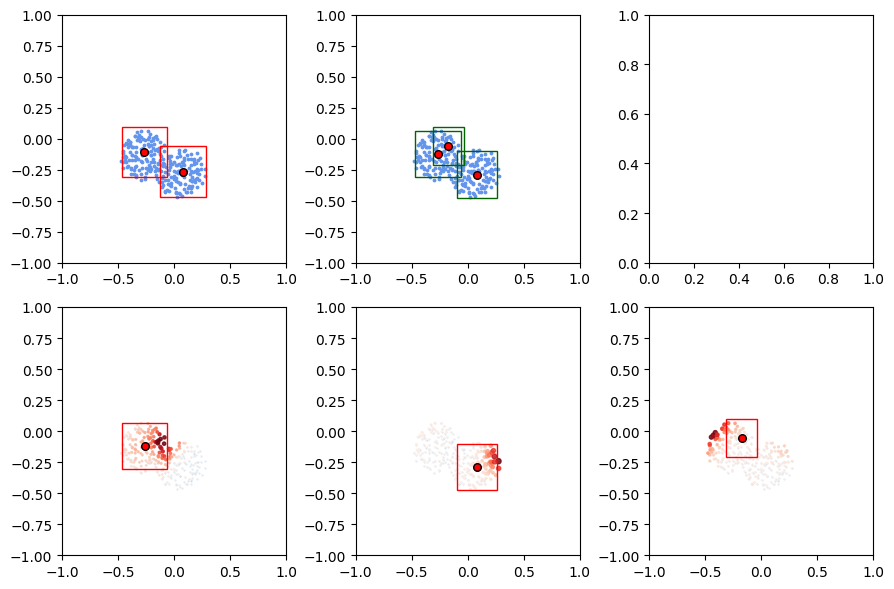

In [58]:
fig,ax = plt.subplots(2,n_objects,figsize=(3*n_objects,6),dpi=100)

for i in range(2):
    ax[0][i].scatter(x,y,c='cornflowerblue',cmap='tab10',s=3)

ax[0][1].scatter(predicted_centers[:,0],predicted_centers[:,1],c='r',cmap='tab10',s=30,ec='k')
ax[0][0].scatter(object_centers[:,0],object_centers[:,1],c='r',marker='o',s=30,ec='k')

for i in range(len(object_height)):
    
    bounding_box = patches.Rectangle((object_centers[i][0]-object_width[i]/2, object_centers[i][1]-object_height[i]/2), 
                             object_width[i], object_height[i], linewidth=1, edgecolor='r', facecolor='none')

    ax[0][0].add_patch(bounding_box) 
    
for i in range(len(predicted_centers)):
    
    bounding_box = patches.Rectangle((predicted_centers[i][0]-predicted_widths[i]/2, 
                                          predicted_centers[i][1]-predicted_heights[i]/2), 
                             predicted_widths[i], predicted_heights[i], linewidth=1, 
                                         edgecolor='darkgreen', facecolor='none')

    ax[0][1].add_patch(bounding_box)

for i in range(2):
    ax[0][i].set_xlim(-1,1)
    ax[0][i].set_ylim(-1,1)

for object_idx in range(n_objects):
    object_attn_weights = []

    for point_i in range(n_points):
        object_attn_weights.append(weight_dict[object_idx][point_i])


    object_attn_weights = torch.softmax(torch.tensor(object_attn_weights),dim=0).data.numpy()

    ax[1][object_idx].scatter(x,y,s=0.2,alpha=0.2)
    ax[1][object_idx].scatter(x,y,s=300.0*object_attn_weights,alpha=0.8,c=object_attn_weights,cmap='Reds')

    ax[1][object_idx].set_xlim(-1,1)
    ax[1][object_idx].set_ylim(-1,1)
    
    bounding_box = patches.Rectangle((predicted_centers[object_idx][0]-predicted_widths[object_idx]/2, 
                                          predicted_centers[object_idx][1]-predicted_heights[object_idx]/2), 
                             predicted_widths[object_idx], predicted_heights[object_idx], linewidth=1, 
                                         edgecolor='r', facecolor='none')


    ax[1][object_idx].scatter(predicted_centers[:,0][object_idx],
                           predicted_centers[:,1][object_idx],c='r',marker='o',s=30,ec='k')
    ax[1][object_idx].add_patch(bounding_box)
    
plt.tight_layout()
plt.show()

The model is able to create correctly boxes around the different clusters. We can notice that, since the size prediction has not been trained, the number of clusters found is wrong.

### Training the size prediction

Now I can freeze everything and only focus on training the size prediction.

In [59]:
training_loss_vs_epoch = []
validation_loss_vs_epoch = []

In [60]:
dataset = RandomShapeDataset('Dataset/training.bin')
validation_ds = RandomShapeDataset('Dataset/validation.bin')

data_loader = DataLoader(dataset, batch_size=300, shuffle=True,
                         collate_fn=collate_graphs)

valid_data_loader = DataLoader(validation_ds, batch_size=300, shuffle=False,
                         collate_fn=collate_graphs)

In [61]:
# I loop over the network, and unless is 'size_predictor', I freeze

for p_name, p in net.named_parameters():
    if 'size_predictor' not in p_name:
        p.requires_grad = False

In [62]:
optimizer = optim.Adam(net.size_predictor.parameters(), lr=0.001) 

In [63]:
if torch.cuda.is_available():
    net.cuda()

In [64]:
if torch.cuda.is_available():
    
    n_epochs = 180

    for epoch in range(n_epochs): 

        if len(validation_loss_vs_epoch) > 0:

            print(epoch, 'train loss',training_loss_vs_epoch[-1],'validation loss',validation_loss_vs_epoch[-1])

        net.train() # put the net into "training mode"

        epoch_loss = 0
        n_batches = 0
        for batched_g in tqdm(data_loader):
            n_batches+=1

            if torch.cuda.is_available():
                batched_g = batched_g.to(torch.device('cuda'))

            optimizer.zero_grad()

            predicted_g,size_pred = net(batched_g)


            loss = size_loss_func(size_pred, batched_g.batch_num_nodes('objects')-2 )

            epoch_loss+=loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = epoch_loss/n_batches
        training_loss_vs_epoch.append(epoch_loss)

        net.eval()
        with torch.no_grad():
            epoch_loss = 0
            n_batches = 0
            for batched_g in tqdm(valid_data_loader):
                n_batches+=1

                if torch.cuda.is_available():
                    batched_g = batched_g.to(torch.device('cuda'))

                predicted_g,size_pred = net(batched_g,use_target_size=True)

                loss = size_loss_func(size_pred, batched_g.batch_num_nodes('objects')-2 )

                epoch_loss+=loss.item()

            epoch_loss = epoch_loss/n_batches
            validation_loss_vs_epoch.append(epoch_loss)

        if len(validation_loss_vs_epoch)==1 or np.amin(validation_loss_vs_epoch[:-1]) > validation_loss_vs_epoch[-1]:
            torch.save(net.state_dict(), 'trained_model.pt')

In [65]:
if torch.cuda.is_available():
    
    plt.plot(training_loss_vs_epoch)
    plt.plot(validation_loss_vs_epoch)

In [66]:
net.cpu()
net.load_state_dict(torch.load('trained_model.pt',map_location='cpu'))

<All keys matched successfully>

### Results with everything trained

In [67]:
net.eval()
net.cpu()
predicted_sizes = []
for batched_g in valid_data_loader:
    predicted_g,size_pred = net(batched_g)
    
    predicted_sizes+=list(torch.argmax(size_pred,dim=1).cpu().data.numpy())
    
predicted_sizes = np.array(predicted_sizes)+2

In [68]:
target_sizes = np.array([validation_ds[i].num_nodes('objects') for i in range(len(validation_ds))])

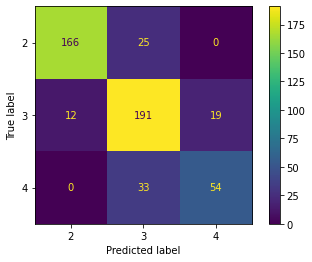

In [69]:
cm = confusion_matrix(target_sizes, predicted_sizes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['2','3','4'])
disp.plot()

In [70]:
g = validation_ds[idxValidation].cpu()

net.eval()
predicted_g, size_pred = net(g) 

In [71]:
predicted_g.num_nodes('predicted objects')

2

In [72]:
x = g.nodes['points'].data['xy'][:,0].data.numpy()
y = g.nodes['points'].data['xy'][:,1].data.numpy()
object_centers = g.nodes['objects'].data['centers'].data.numpy()

object_width = g.nodes['objects'].data['width'].data.numpy()
object_height = g.nodes['objects'].data['height'].data.numpy()

predicted_heights = predicted_g.nodes['predicted objects'].data['properties'][:,0].data.numpy()
predicted_widths = predicted_g.nodes['predicted objects'].data['properties'][:,1].data.numpy()
predicted_centers = predicted_g.nodes['predicted objects'].data['properties'][:,[2,3]].data.numpy()

attn_weights = predicted_g.edges['points_to_object'].data['attention weights'].cpu().data.numpy()

In [73]:
n_points = predicted_g.num_nodes('points')
n_objects = predicted_g.num_nodes('predicted objects')
n_objects

2

In [74]:
estart = predicted_g.edges(etype='points_to_object')[0].cpu().data.numpy()
eend =  predicted_g.edges(etype='points_to_object')[1].cpu().data.numpy()

weight_dict = {i:{} for i in range(n_objects)}
for e_i,(es,ee) in enumerate(zip(estart,eend)):
    weight_dict[ee][es] = attn_weights[e_i]

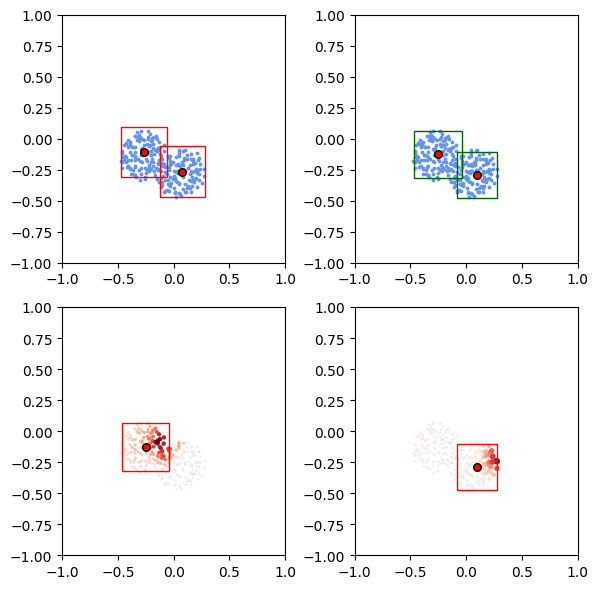

In [75]:
fig,ax = plt.subplots(2,n_objects,figsize=(3*n_objects,6),dpi=100)

for i in range(2):
    ax[0][i].scatter(x,y,c='cornflowerblue',cmap='tab10',s=3)

ax[0][1].scatter(predicted_centers[:,0],predicted_centers[:,1],c='r',cmap='tab10',s=30,ec='k')
ax[0][0].scatter(object_centers[:,0],object_centers[:,1],c='r',marker='o',s=30,ec='k')

for i in range(len(object_height)):
    
    bounding_box = patches.Rectangle((object_centers[i][0]-object_width[i]/2, object_centers[i][1]-object_height[i]/2), 
                             object_width[i], object_height[i], linewidth=1, edgecolor='r', facecolor='none')


    ax[0][0].add_patch(bounding_box) 
    
for i in range(len(predicted_centers)):
    
    bounding_box = patches.Rectangle((predicted_centers[i][0]-predicted_widths[i]/2, 
                                          predicted_centers[i][1]-predicted_heights[i]/2), 
                             predicted_widths[i], predicted_heights[i], linewidth=1, 
                                         edgecolor='darkgreen', facecolor='none')

    ax[0][1].add_patch(bounding_box)

for i in range(2):
    ax[0][i].set_xlim(-1,1)
    ax[0][i].set_ylim(-1,1)

for object_idx in range(n_objects):
    object_attn_weights = []

    for point_i in range(n_points):
        object_attn_weights.append(weight_dict[object_idx][point_i])

    object_attn_weights = torch.softmax(torch.tensor(object_attn_weights),dim=0).data.numpy()

    ax[1][object_idx].scatter(x,y,s=0.2,alpha=0.2)
    ax[1][object_idx].scatter(x,y,s=300.0*object_attn_weights,alpha=0.8,c=object_attn_weights,cmap='Reds')

    ax[1][object_idx].set_xlim(-1,1)
    ax[1][object_idx].set_ylim(-1,1)
    
    bounding_box = patches.Rectangle((predicted_centers[object_idx][0]-predicted_widths[object_idx]/2, 
                                          predicted_centers[object_idx][1]-predicted_heights[object_idx]/2), 
                             predicted_widths[object_idx], predicted_heights[object_idx], linewidth=1, 
                                         edgecolor='r', facecolor='none')


    ax[1][object_idx].scatter(predicted_centers[:,0][object_idx],
                           predicted_centers[:,1][object_idx],c='r',marker='o',s=30,ec='k')
    ax[1][object_idx].add_patch(bounding_box)
    
plt.tight_layout()
plt.show()

Now the model correctly does its job!